In [1]:
import pandas as pd

### Loading and inspecting

In [2]:
# Load the datasets
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [3]:
# Inspect the datasets
print(movies.head())
print(ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510


### Data preprocessing

In [4]:
# Merge datasets
data = pd.merge(ratings, movies, on='movieId')

In [7]:
# Sample data
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


In [5]:
# Check for missing values
print(data.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


### Exploratory data analysis

<Axes: xlabel='rating'>

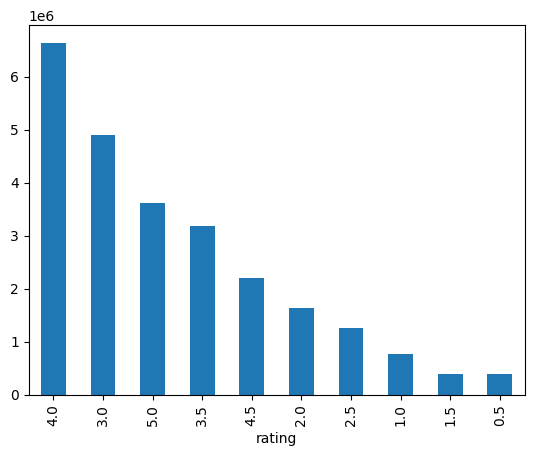

In [6]:
# Distribution of ratings
data['rating'].value_counts().plot(kind='bar')

In [8]:
# Most popular movies
popular_movies = data.groupby('title').size().sort_values(ascending=False).head(10)
popular_movies.head()

title
Forrest Gump (1994)                 81491
Shawshank Redemption, The (1994)    81482
Pulp Fiction (1994)                 79672
Silence of the Lambs, The (1991)    74127
Matrix, The (1999)                  72674
dtype: int64

### Build the recommender system